In [11]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [12]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Percorsi delle directory contenenti le facce estratte dai video FAKE e REAL
FAKE_FACES_PATH = "/Volumes/Macintosh SSD/Developer/TEST 4000 faces/FAKE_faces_4000"
REAL_FACES_PATH = "/Volumes/Macintosh SSD/Developer/TEST 4000 faces/REAL_faces_4000"

# Etichette per i video REAL e FAKE
LABELS = {"REAL": 0, "FAKE": 1}

# Inizializza le liste per le facce, le etichette e le origini
faces = []
labels = []
origins = []

# Funzione per caricare le immagini da una directory e assegnare le etichette
def load_faces_from_directory(directory, label, origin_label):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
               # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # opzionale, se ti serve RGB vero
                img = img.astype("float32")
                faces.append(img)
                labels.append(label)
                origins.append(origin_label)
                count += 1
    print(f"Caricate {count} immagini dalla directory {directory}")

# Carica le facce dai video FAKE
print("Inizio caricamento facce dai video FAKE")
load_faces_from_directory(FAKE_FACES_PATH, LABELS["FAKE"], "FAKE")

# Carica le facce dai video REAL
print("Inizio caricamento facce dai video REAL")
load_faces_from_directory(REAL_FACES_PATH, LABELS["REAL"], "REAL")

# Converti le liste in array numpy
print("Converti delle liste in array numpy")
faces = np.array(faces)
labels = np.array(labels)
origins = np.array(origins)
print("Conversione effettuata delle liste in array numpy")

print("Shape dell'array:", faces.shape)
print("Tipo dati prima della normalizzazione:", faces.dtype)
print("RAM stimata:", round(faces.nbytes / (1024**3), 2), "GB")

# Normalize RGB values
print("Inizio normalizzazione di faces")
faces = faces / 255.0
print("Normalizzazione effettuata correttamente per faces")

print("Tipo dati dopo normalizzazione:", faces.dtype)
print("RAM stimata:", faces.nbytes / (1024**3), "GB")

# Stampa il numero totale di facce caricate
print(f"Totale facce caricate: {len(faces)}")
print(f"Totale etichette caricate: {len(labels)}")
print(f"Totale origini caricate: {len(origins)}")

# Split del dataset in training, validation e test set
print("Inizio split del dataset")
X_train, X_temp, y_train, y_temp, origins_train, origins_temp = train_test_split(faces, labels, origins, test_size=0.28, random_state=42)
X_val, X_test, y_val, y_test, origins_val, origins_test = train_test_split(X_temp, y_temp, origins_temp, test_size=0.5, random_state=42)
print("Split del dataset completato")

# Stampa delle dimensioni dei dataset dopo lo split
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Inizio caricamento facce dai video FAKE
Caricate 4000 immagini dalla directory /Volumes/Macintosh SSD/Developer/TEST 4000 faces/FAKE_faces_4000
Inizio caricamento facce dai video REAL
Caricate 4000 immagini dalla directory /Volumes/Macintosh SSD/Developer/TEST 4000 faces/REAL_faces_4000
Converti delle liste in array numpy
Conversione effettuata delle liste in array numpy
Shape dell'array: (8000, 224, 224, 3)
Tipo dati prima della normalizzazione: float32
RAM stimata: 4.49 GB
Inizio normalizzazione di faces
Normalizzazione effettuata correttamente per faces
Tipo dati dopo normalizzazione: float32
RAM stimata: 4.486083984375 GB
Totale facce caricate: 8000
Totale etichette caricate: 8000
Totale origini caricate: 8000
Inizio split del dataset
Split del dataset completato
Training set: 5760 samples
Validation set: 1120 samples
Test set: 1120 samples


In [ ]:
# --- BLOCCO DI CARICAMENTO DEL MODELLO ---
# Se carichi un modello precedentemente addestrato salta la fase di training

# Import necessario per riconoscere l’optimizer legacy usato nel salvataggio
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model

# Caricamento del modello completo
model = load_model("deepfake_model.keras")
print("✅ Modello caricato correttamente dal file .keras (con legacy.Adam)")

In [ ]:
# --- BLOCCO DI TRAINING DEL MODELLO ---

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam #At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs
from tensorflow.keras.optimizers.legacy import Adam #Please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

# Carica il modello pre-addestrato VGG16 senza il top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela i pesi del modello pre-addestrato
for layer in base_model.layers:
    layer.trainable = False

# Aggiungi i tuoi livelli di classificazione
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Crea il modello
model = Model(inputs=base_model.input, outputs=x)

# Compila il modello
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

# Valuta il modello
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/20
180/180 [==============================] - 729s 4s/step - loss: 0.6295 - accuracy: 0.6540 - val_loss: 0.5433 - val_accuracy: 0.7223
Epoch 2/20
180/180 [==============================] - 705s 4s/step - loss: 0.4948 - accuracy: 0.7500 - val_loss: 0.4857 - val_accuracy: 0.7688
Epoch 3/20
180/180 [==============================] - 734s 4s/step - loss: 0.4308 - accuracy: 0.7922 - val_loss: 0.4890 - val_accuracy: 0.7527
Epoch 4/20
180/180 [==============================] - 702s 4s/step - loss: 0.4012 - accuracy: 0.8082 - val_loss: 0.5424 - val_accuracy: 0.7295
Epoch 5/20
180/180 [==============================] - 715s 4s/step - loss: 0.3334 - accuracy: 0.8552 - val_loss: 0.4376 - val_accuracy: 0.7911
Epoch 6/20
180/180 [==============================] - 684s 4s/step - loss: 0.3056 - accuracy: 0.8712 - val_loss: 0.4278 - val_accuracy: 0.7973
Epoch 7/20
180/180 [==============================] - 665s 4s/step - loss: 0.2776 - accuracy: 0.8889 - val_loss: 0.4224 - val_accuracy: 0.8000

In [ ]:
# --- BLOCCO DI SALVATAGGIO DEL MODELLO ---

# Salvataggio del modello completo (architettura + pesi + configurazione + ottimizzatore) in formato legacy HDF5
model.save("deepfake_model_vgg16.h5")
print("✅ Modello salvato in deepfake_model_vgg16.h5")

/Users/vittoriostile/anaconda3/envs/testEnv1/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Modello salvato in deepfake_model_vgg16.h5


In [21]:
# --- BLOCCO DI SALVATAGGIO DEL MODELLO ---

# Salvataggio del modello completo (architettura + pesi + configurazione + ottimizzatore) in formato moderno Keras
model.save("deepfake_model_vgg16.keras")
print("✅ Modello salvato con legacy.Adam nel formato .keras")

✅ Modello salvato con legacy.Adam nel formato .keras


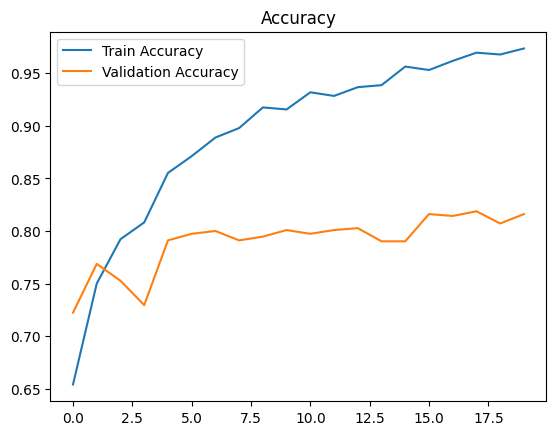

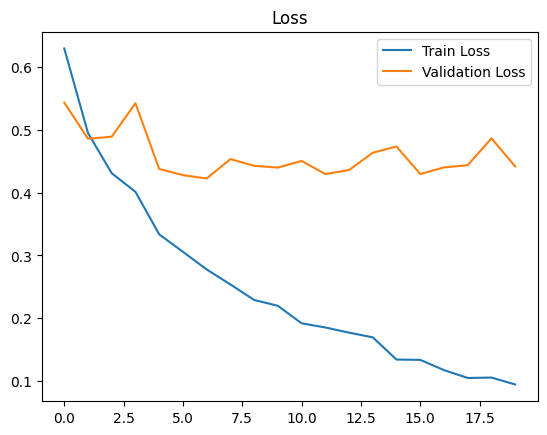

In [14]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy') # history.history['accuracy']: Contiene i valori di accuratezza calcolati dal modello su ogni epoca per il training set
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # history.history['val_accuracy']: valori calcolati sul validation set dopo ogni epoca, ci dice quanto bene il modello generalizza su dati non visti durante il training
plt.legend() # Stampa la leggenda in basso a dx
plt.title('Accuracy') # Da il titolo al grafico in alto
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss') # history.history['loss']: i valori della funzione di perdita calcolati dal modello sul training set durante ogni epoca
plt.plot(history.history['val_loss'], label='Validation Loss') # history.history['val_loss']: i valori calcolati sul validation set dopo ogni epoca, ci dice quanto bene il modello generalizza su dati non visti
plt.legend()
plt.title('Loss')
plt.show()


## Test del modello
### Spiegazione del codice di seguito:

1. Calcola il numero totale di frame analizzati.
2. Calcola il numero di frame FAKE e REAL correttamente identificati.
3. Calcola la percentuale di frame correttamente identificati.
4. Stampa una leggenda che spiega cosa significano le etichette 1 e 0.
5. Stampa il numero totale di frame analizzati, il numero di frame FAKE e REAL correttamente identificati, e la percentuale di frame correttamente identificati.
6. Stampa la lista dei frame correttamente identificati con la percentuale predetta e l'etichetta reale.
7. Stampa il numero di frame non correttamente riconosciuti e la lista dei frame non correttamente riconosciuti con la percentuale predetta e l'etichetta reale.


In [ ]:
# Predizione delle probabilità sui frame di test
predictions = model.predict(X_test)  # Probabilità per ogni frame
predicted_labels = (predictions > 0.50).astype(int).flatten()  # Soglia: % per decretare un video come FAKE. Per sicurezza "appiattiamo" che serve per appiattire array multidimensionali in un array 1D. Esempio: da [[1], [0], [1]] a [1, 0, 1].

# Ground truth
true_labels = y_test.flatten() # Questo rappresenta la ground truth: ovvero le etichette reali (0 per REAL, 1 per FAKE) che il modello deve imparare a predire.

# Indici dei frame predetti come FAKE e REAL
fake_indices = np.where(predicted_labels == 1)[0]  # Indici dei frame FAKE
real_indices = np.where(predicted_labels == 0)[0]  # Indici dei frame REAL

# Frame realmente REAL e FAKE
num_real_fake_frames = np.sum(true_labels == 1)
num_real_real_frames = np.sum(true_labels == 0)

# Frame identificati come FAKE e REAL
num_fake_frames = len(fake_indices)
num_real_frames = len(real_indices)

# Frame correttamente predetti
num_correct_fake_frames = np.count_nonzero((predicted_labels == 1) & (true_labels == 1))
num_correct_real_frames = np.count_nonzero((predicted_labels == 0) & (true_labels == 0))

# Frame FAKE identificati come REAL e REAL identificati come FAKE
num_fake_as_real = np.count_nonzero((predicted_labels == 0) & (true_labels == 1)) # False Negatives
num_real_as_fake = np.count_nonzero((predicted_labels == 1) & (true_labels == 0)) # False Positive


# Percentuali
percent_fake_frames = (num_fake_frames / num_real_fake_frames) * 100
percent_real_frames = (num_real_frames / num_real_real_frames) * 100
percent_correct_fake = (num_correct_fake_frames / num_real_fake_frames) * 100
percent_correct_real = (num_correct_real_frames / num_real_real_frames) * 100

# Output
print("📌 Leggenda: Etichetta 1 = FAKE, Etichetta 0 = REAL — Soglia di classificazione: > 50%\n")

print(f"🎞️  Numero totale di frame analizzati: {len(true_labels)}")
print(f"✅ Numero di frame realmente REAL: {num_real_real_frames}")
print(f"❌ Numero di frame realmente FAKE: {num_real_fake_frames}\n")

print(f"🧠 Numero di frame identificati come FAKE: {num_fake_frames} ({percent_fake_frames:.2f}%)")
print(f"🧠 Numero di frame identificati come REAL: {num_real_frames} ({percent_real_frames:.2f}%)\n")

print(f"✔️ Frame FAKE correttamente identificati (True Positives): {num_correct_fake_frames} ({percent_correct_fake:.2f}%)")
print(f"✔️ Frame REAL correttamente identificati (True Negatives): {num_correct_real_frames} ({percent_correct_real:.2f}%)\n")

print(f"⚠️ Frame FAKE identificati come REAL (False Negatives): {num_fake_as_real}")
print(f"⚠️ Frame REAL identificati come FAKE (False Positive): {num_fake_as_real}\n")


# Calcolo e stampa errori
fake_over_detection = num_fake_frames - num_real_fake_frames
fake_error_percentage = (fake_over_detection / num_real_fake_frames) * 100

real_under_detection = num_real_real_frames - num_real_frames
real_error_percentage = (real_under_detection / num_real_real_frames) * 100

percent_correct_fake_estimated = ((num_real_fake_frames - fake_over_detection) / num_real_fake_frames) * 100

print("📊 Errori percentuali calcolati:\n")

print(f"🔺 Errore in eccesso su FAKE (falsi positivi):")
print(f"→ Identificati {num_fake_frames} vs {num_real_fake_frames} reali → {fake_over_detection} in più")
print(f"→ Errore percentuale: +{fake_error_percentage:.2f}%\n")

print(f"🔻 Errore in difetto su REAL (falsi negativi):")
print(f"→ {num_real_real_frames} reali vs {num_real_frames} riconosciuti → {real_under_detection} mancanti")
print(f"→ Errore percentuale: −{real_error_percentage:.2f}%\n")

print(f"✅ Percentuale stimata di FAKE correttamente identificati: {percent_correct_fake_estimated:.2f}%")

print("Percentuale di predizione per ogni frame (con etichetta associata):")
for i in range(total_frames):
    predizione_errata = "PREDIZIONE ERRATA" if predicted_labels[i] != predicted_labels[i] else ""
    print(f"Frame {i + 1}: {predictions[i][0]:.2f} (Etichetta reale: {predicted_labels[i]}) {predizione_errata}")

print("Lista dei frame FAKE riconosciuti con la percentuale predetta:")
for i in fake_indices:
    predizione_errata = "PREDIZIONE ERRATA" if predicted_labels[i] != predicted_labels[i] else ""
    print(f"Frame {i + 1}: {predictions[i][0]:.2f} (Etichetta reale: {predicted_labels[i]}) {predizione_errata}")

print("Lista dei frame REAL riconosciuti con la percentuale predetta:")
for i in real_indices:
    predizione_errata = "PREDIZIONE ERRATA" if predicted_labels[i] != predicted_labels[i] else ""
    print(f"Frame {i + 1}: {predictions[i][0]:.2f} (Etichetta reale: {predicted_labels[i]}) {predizione_errata}")

35/35 [==============================] - 116s 3s/step
📌 Leggenda: Etichetta 1 = FAKE, Etichetta 0 = REAL — Soglia di classificazione: > 50%

🎞️  Numero totale di frame analizzati: 1120
✅ Numero di frame realmente REAL: 555
❌ Numero di frame realmente FAKE: 565

🧠 Numero di frame identificati come FAKE: 597 (105.66%)
🧠 Numero di frame identificati come REAL: 523 (94.23%)

✔️ Frame FAKE correttamente identificati (True Positives): 488 (86.37%)
✔️ Frame REAL correttamente identificati (True Negatives): 446 (80.36%)

⚠️ Frame FAKE identificati come REAL (False Negatives): 77

📊 Errori percentuali calcolati:

🔺 Errore in eccesso su FAKE (falsi positivi):
→ Identificati 597 vs 565 reali → 32 in più
→ Errore percentuale: +5.66%

🔻 Errore in difetto su REAL (falsi negativi):
→ 555 reali vs 523 riconosciuti → 32 mancanti
→ Errore percentuale: −5.77%

✅ Percentuale stimata di FAKE correttamente identificati: 94.34%
Percentuale di predizione per ogni frame (con etichetta associata):
Frame 1: 0.31